<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

Este cuaderno forma parte del proyecto de colaboración entre IBiDat y Santander Corporation que busca estudiar la aplicabilidad de técnicas de fairness en Machine Learning (ML) en el ámbito financiero. El cuaderno proporciona un contenido principalmente práctico en el cual se aplicarán las distintas técnicas planteadas a nivel teórico en el report complementario.

## Metodologías consideradas 
Se trabajará con 8 técnicas de obtención de fairness diferentes que se agrupan en 3 categorías en función del punto en el que se apliquen dentro de un pipeline de ML:

<img src="img/plotFairness.jpg" alt="drawing" width="900"/>

**Técnicas de preprocesado:** 
* Reponderación (reweighing)
* Eliminador de impacto dispar (disparate impact remover)

**Técnicas de inprocesado**:
* Eliminador de prejuicios por regularización (prejudice remover)
* Eliminación de prejuicios adversarios (adversarial debiasing)
* Algoritmo de metafairness (metafairness algorithm)

**Técnicas de postprocesado**
* Clasificación de rechazo de opción (reject option classification)
* Escalado de Platt por grupos (group-wise Platt scaling)
* Procesasor de probabilidades igualadas (equalized odds processor)

## Evaluación de resultados

Para evaluar las diferentes metodologías se considerará un esquema común en cuanto a algoritmos, conjuntos de datos y métricas.

### Algoritmos 
Se utilizará un algoritmo tradicional y un algoritmo ML.
* Regresión logística: este es uno de los algoritmos de clasificación más utilizado por su facilidad de implementación e interpretación, y es un algoritmo que sigue en vigor en áreas de las finanzas como el credit scoring, por lo que se selecciona como un referente de las metodologías tradicionales.
* Ensemble tipo xgboost: el xgboost es un ensemble de modelos basados en árboles de decisión que se ha convertido en un estándar en multitud de industrias por la calidad de sus predicciones, por lo que se selecciona como referente de las metodologías ML.
Además de estos algoritmos, de forma puntual podrán utilizarse otros si son requeridos por una metodología concreta, como es el caso por ejemplo del algoritmo de *eliminación de prejuicios adversarios*, que se basa en el uso de redes neuronales.

### Conjuntos de datos 
Cada metodología se evaluará en dos conjuntos de datos de diferente tamaño.

| Nombre     | Tamaño muestral | Número de variables | Ratio de default | Ratio del atributo sensible |
|------------|-----------------|---------------------|------------------|-----------------------------|
| German     | 1000            | 61                  | 0.3              | 0.19                        |
| Homecredit | 307511          | 122                 | 0.08             | 0.04                        |

En ambos conjuntos de datos se considerará que el atributo sensible es la edad. Una persona pertenecerá al grupo sensible si es menor de 25 años. En este caso lo aplicaremos al dataset `homecredit`.

### Métricas 
Cada metodología se evaluará en un conjunto de métricas que represente por un lado, la calidad predictiva del modelo, y por otro, el nivel de sesgo presente en sus predicciones. Dado que existen varias definiciones diferentes de fairness, se considerarán 3 métricas para medir el nivel de sesgo, cada una asociada a una definición.

**Calidad predictiva**
* AUC: área bajo la curva ROC
* Accuracy: $\dfrac{TP+TN}{TP+TN+FP+FN}$.
* Balanced accuracy: $\dfrac{TPR+TNR}{2}$. Métrica usada en problemas de clasificación no balanceados.

**Nivel de sesgo**: Sea $A$ la variable que denota el atributo sensible. Entonces se definen las siguientes métricas,
* Statistical parity difference (independencia): $\Pr(\hat{Y} = 1 | A = 0) - Pr(\hat{Y} = 1 | A = 1)$. Valores menores que 0 indican que el grupo privilegiado tiene una mayor proporción de predicciones positivas que el no privilegiado.
* Positive predicted value (suficiencia): $|PPV_{A = 0} - PPV_{A = 1}|$
* Average odds difference (separación): $\dfrac{|FPR_{A = 0} - FPR_{A = 1}| + |TPR_{A = 0} - TPR_{A = 1}|}{2}$

Además de estas métricas, en aquellos casos en que alguna metodología particular obtenga el fairness optimizando una métrica particular, dicha métrica también se incorporará a los resultados presentados aquí.



# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:
dataset_name = 'homecredit' # valid options are: german; homecredit

if dataset_name == 'german':
    dataset_german = GermanDataset(
        protected_attribute_names=['age'],            
        privileged_classes=[lambda x: x >= 25],      
        features_to_drop=['personal_status', 'sex'] 
    )
    

    # xgboost requiere que los labels empiecen en 0, y en este conjunto empiezan en 1
    # dataset_german.labels = dataset_german.labels - 1
    # dataset_german.favorable_label = dataset_german.favorable_label - 1
    # dataset_german.unfavorable_label = dataset_german.unfavorable_label - 1
    # cambiar los labels 2 a 0 (label 2 es desfavorabel y 1 es favorable) 
    dataset_german.labels[dataset_german.labels.ravel() == 2] =  dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
    dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2

    
    
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_german.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_german)
    
    print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_german.favorable_label)
    print("Label del grupo desfavorable:", dataset_german.unfavorable_label) 
    
elif dataset_name == 'homecredit':
    dataset_homecredit = pd.read_csv('data/homecredit.zip', compression='zip', header=0, sep=',', quotechar='"')

    dataset_homecredit = utils.preprocess_homecredit(dataset_homecredit)

    dataset_homecredit_aif = utils.convert_to_standard_dataset(
            df=dataset_homecredit,
            target_label_name='TARGET',
            sensitive_attribute='AGE',
            priviledged_classes=[lambda x: x >= 25],
            favorable_target_label=[1],
            features_to_keep=[],
            categorical_features=[])

    # para hacer submuestra 
    sample_size_hc = 5000
    dataset_homecredit_aif = dataset_homecredit_aif.subset(np.random.randint(0, 307511+1, size=(sample_size_hc)))
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_homecredit_aif.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_homecredit_aif.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_homecredit_aif)

    print(f'Dimensiones del conjunto de datos: {dataset_homecredit_aif.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_homecredit_aif.favorable_label)
    print("Label del grupo desfavorable:", dataset_homecredit_aif.unfavorable_label) 
else:
    print('Invalid dataset selected')

/home/arturo_perez/DEFINITIVO/utils.py:1129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AGE'] = -df['DAYS_BIRTH'].astype('float') / 365


Dimensiones del conjunto de datos: (5000, 226)
Grupos privilegiados: [{'AGE': 1.0}]
Grupos no privilegiados: [{'AGE': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [4]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [5]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 1.14 s, sys: 1.03 s, total: 2.17 s
Wall time: 2.17 s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5564
Balanced accuracy: 0.5751
Accuracy: 0.3840
Independence ( |ΔP(Y_pred = 1)| ): 0.2670
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1561
Sufficiency ( |ΔPPV| ) : 0.0719
CPU times: user 22.7 s, sys: 33.1 s, total: 55.8 s
Wall time: 48 s


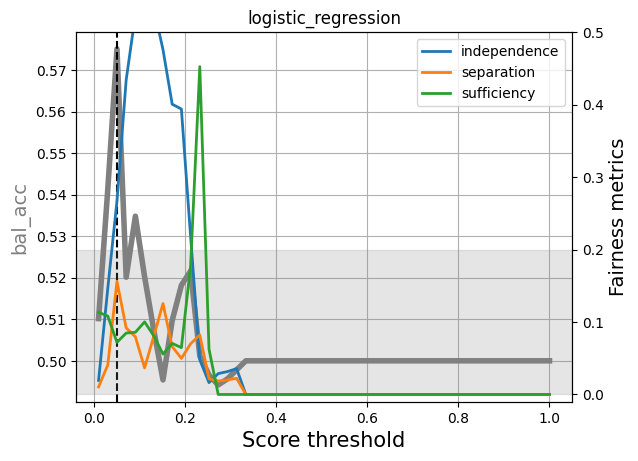

In [6]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [7]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5256
Balanced accuracy: 0.5001
Accuracy: 0.3347
Independence ( |ΔP(Y_pred = 1)| ): 0.3085
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0005
Sufficiency ( |ΔPPV| ) : 0.0063


### XGBoost

In [8]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 50min 7s, sys: 2.66 s, total: 50min 10s
Wall time: 1min 19s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.6707
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.3065
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1560
Sufficiency ( |ΔPPV| ) : 0.0687
CPU times: user 25.2 s, sys: 19.3 s, total: 44.6 s
Wall time: 1min 12s


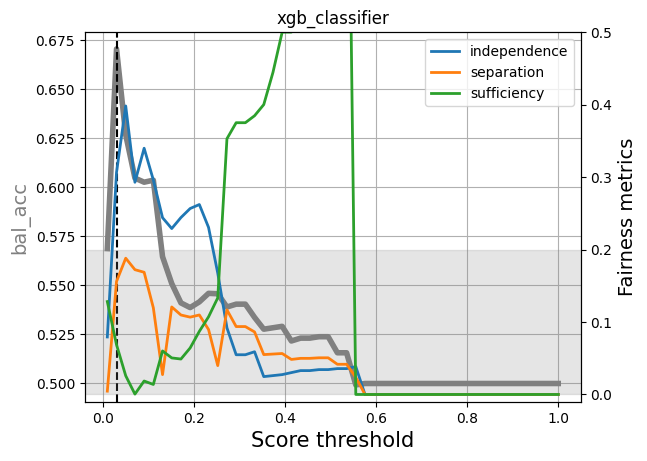

In [9]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [10]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.6848
Balanced accuracy: 0.6373
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.4497
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0952
Sufficiency ( |ΔPPV| ) : 0.0477


## Técnicas de preprocesado

### Reponderación

In [11]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: user 2.71 s, sys: 2.21 s, total: 4.92 s
Wall time: 8.05 s


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5565
Balanced accuracy: 0.5711
Accuracy: 0.3765
Independence ( |ΔP(Y_pred = 1)| ): 0.2730
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1524
Sufficiency ( |ΔPPV| ) : 0.0077
CPU times: user 24.5 s, sys: 28.1 s, total: 52.6 s
Wall time: 57.3 s


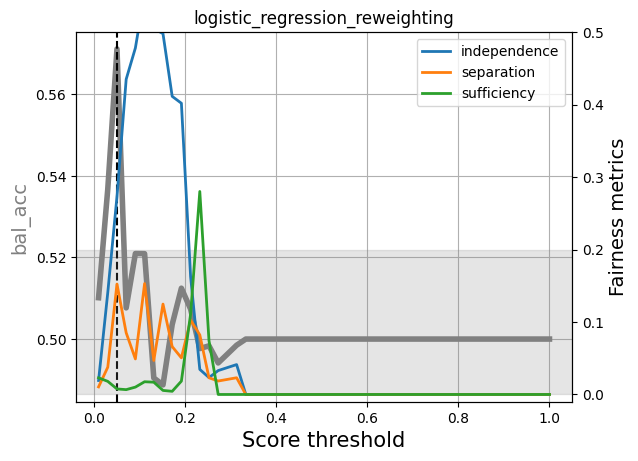

In [12]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.6700
Accuracy: 0.5724
Independence ( |ΔP(Y_pred = 1)| ): 0.3022
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1560
Sufficiency ( |ΔPPV| ) : 0.0265
CPU times: user 48min 43s, sys: 22.9 s, total: 49min 6s
Wall time: 3min 15s


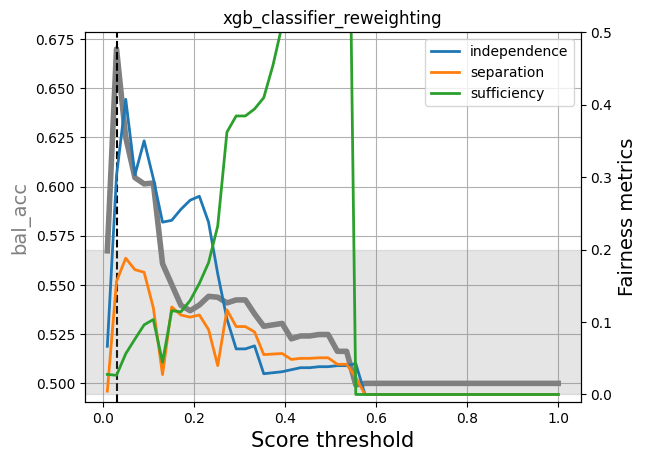

In [13]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


### Eliminador de impacto dispar

In [14]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)



CPU times: user 6.93 s, sys: 1.57 s, total: 8.5 s
Wall time: 9.73 s


Aplicamos los métodos de regresión logística y XGBoost

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5630
Balanced accuracy: 0.5582
Accuracy: 0.3667
Independence ( |ΔP(Y_pred = 1)| ): 0.2120
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1137
Sufficiency ( |ΔPPV| ) : 0.0836
CPU times: user 28.1 s, sys: 31.5 s, total: 59.7 s
Wall time: 55.7 s


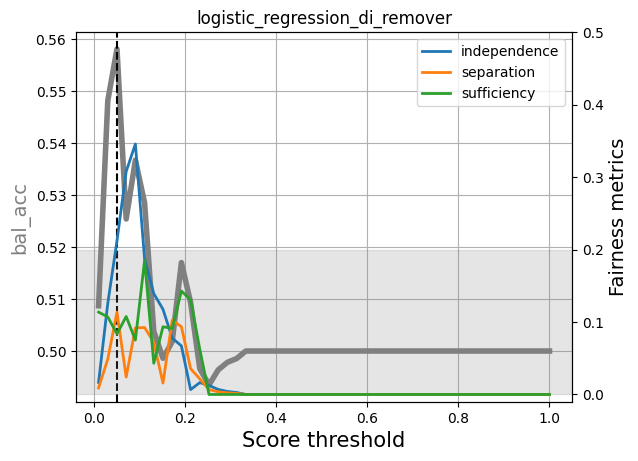

In [15]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.6661
Accuracy: 0.5787
Independence ( |ΔP(Y_pred = 1)| ): 0.2750
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1263
Sufficiency ( |ΔPPV| ) : 0.0802
CPU times: user 46min 1s, sys: 24 s, total: 46min 25s
Wall time: 2min 56s


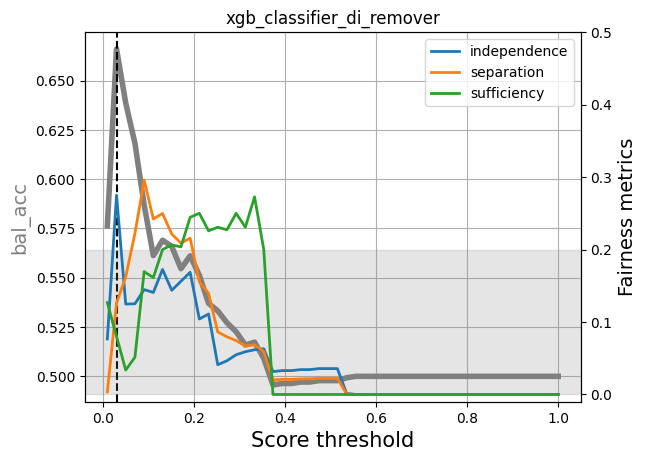

In [16]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


## Técnicas de inprocesado

### Eliminador de prejuicios por regularización

In [17]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [18]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [19]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_m

CPU times: user 10min 55s, sys: 14min 35s, total: 25min 30s
Wall time: 3min 40s


In [20]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5218
Balanced accuracy: 0.5000
Accuracy: 0.0813
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1150


Results for meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5215
Balanced accuracy: 0.5000
Accuracy: 0.0813
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1150


CPU times: user 51.4 s, sys: 1min 10s, total: 2min 1s
Wall time: 1min 49s


### Eliminación de prejuicios adversarios

In [21]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

2024-06-16 21:16:49.871435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-16 21:16:50.217327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 20776.005859; batch adversarial loss: 0.389701
epoch 1; iter: 0; batch classifier loss: 5360.077148; batch adversarial loss: 0.650302
epoch 2; iter: 0; batch classifier loss: 5571.795898; batch adversarial loss: 0.651026
epoch 3; iter: 0; batch classifier loss: 4912.900879; batch adversarial loss: 0.624157
epoch 4; iter: 0; batch classifier loss: 6807.749512; batch adversarial loss: 0.606824
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: na

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5000
Balanced accuracy: 0.5000
Accuracy: 0.0813
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1150
CPU times: user 26.5 s, sys: 31.5 s, total: 58 s
Wall time: 58.3 s


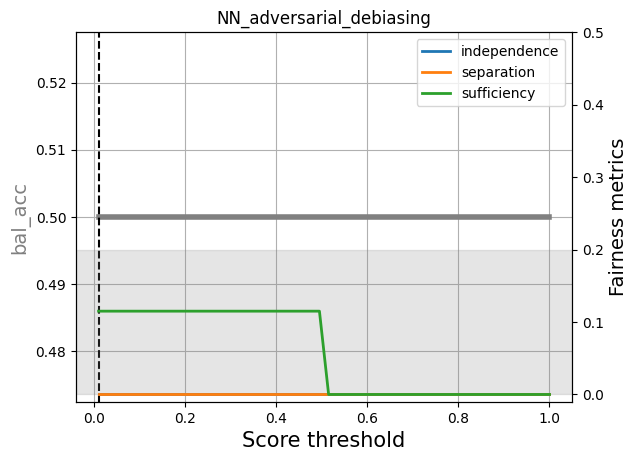

In [22]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [23]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 12135.990234
epoch 1; iter: 0; batch classifier loss: 3245.672119
epoch 2; iter: 0; batch classifier loss: 2600.334961
epoch 3; iter: 0; batch classifier loss: 6727.469727
epoch 4; iter: 0; batch classifier loss: 2684.449463
epoch 5; iter: 0; batch classifier loss: 2763.985352
epoch 6; iter: 0; batch classifier loss: 2370.550293
epoch 7; iter: 0; batch classifier loss: 1999.185913
epoch 8; iter: 0; batch classifier loss: 1825.502686
epoch 9; iter: 0; batch classifier loss: 1330.955322
epoch 10; iter: 0; batch classifier loss: 1389.621582
epoch 11; iter: 0; batch classifier loss: 946.550903
epoch 12; iter: 0; batch classifier loss: 409.635193
epoch 13; iter: 0; batch classifier loss: 1138.013306
epoch 14; iter: 0; batch classifier loss: 327.797363
epoch 15; iter: 0; batch classifier loss: 215.656281
epoch 16; iter: 0; batch classifier loss: 98.201187
epoch 17; iter: 0; batch classifier loss: 230.466995
epoch 18; iter: 0; batch classifier loss: 16

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0706
AUC: 0.4877
Balanced accuracy: 0.5161
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.1920
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1881
Sufficiency ( |ΔPPV| ) : 0.2315
CPU times: user 24.7 s, sys: 27.1 s, total: 51.8 s
Wall time: 51.8 s


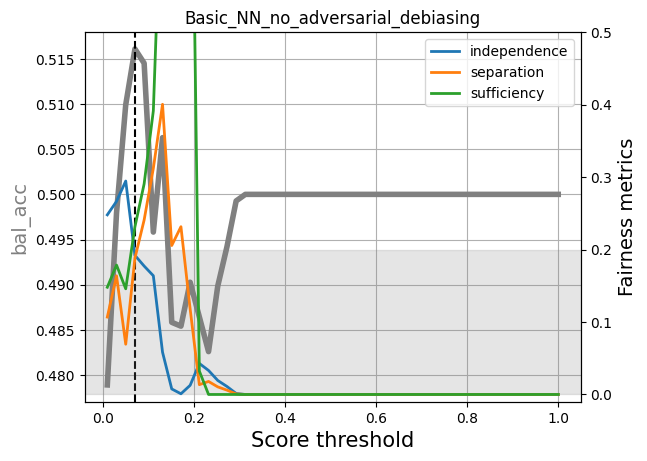

In [24]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de postprocesado 

### Clasificación de rechazo de opción

In [25]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 35 s, sys: 13.5 s, total: 48.5 s
Wall time: 38.8 s


In [26]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3664
AUC: 0.5564
Balanced accuracy: 0.5000
Accuracy: 0.9187
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.3664
AUC: 0.5564
Balanced accuracy: 0.5000
Accuracy: 0.9187
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5564
Balanced accuracy: 0.5152
Accuracy: 0.1093
Independence ( |ΔP(Y_pred = 1)| ): 0.0290
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0157
Sufficiency ( |ΔPPV| ) : 0.1126




In [27]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 39.5 s, sys: 2.56 s, total: 42 s
Wall time: 36.2 s


In [28]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.7722
AUC: 0.7087
Balanced accuracy: 0.5000
Accuracy: 0.9187
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2377
AUC: 0.7087
Balanced accuracy: 0.5400
Accuracy: 0.8960
Independence ( |ΔP(Y_pred = 1)| ): 0.2361
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0830
Sufficiency ( |ΔPPV| ) : 0.1071


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.1783
AUC: 0.7087
Balanced accuracy: 0.5365
Accuracy: 0.8760
Independence ( |ΔP(Y_pred = 1)| ): 0.2524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1045
Sufficiency ( |ΔPPV| ) : 0.0500




### Escalado de Platt por grupos

In [29]:
%%time
fairness_method = '_platt_scaling'
model_names = ['logistic_regression', 'xgb_classifier']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.0829
AUC: 0.5719
Balanced accuracy: 0.5257
Accuracy: 0.8973
Independence ( |ΔP(Y_pred = 1)| ): 1.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1923

Validation set results for xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.0739
AUC: 0.7149
Balanced accuracy: 0.6602
Accuracy: 0.6227
Independence ( |ΔP(Y_pred = 1)| ): 0.6105
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1567
Sufficiency ( |ΔPPV| ) : 0.0576
CPU times: user 48.5 s, sys: 56.8 s, total: 1min 45s
Wall time: 1min 41s


In [30]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

### Procesador de probabilidades igualadas

#### Usando labels

In [31]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [33]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [35]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 6.05 s, sys: 13.4 s, total: 19.5 s
Wall time: 7.48 s


In [36]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5564
Balanced accuracy: 0.5751
Accuracy: 0.3840
Independence ( |ΔP(Y_pred = 1)| ): 0.2670
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1561
Sufficiency ( |ΔPPV| ) : 0.0719


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5564
Balanced accuracy: 0.5826
Accuracy: 0.3840
Independence ( |ΔP(Y_pred = 1)| ): 0.3439
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0799
Sufficiency ( |ΔPPV| ) : 0.0976


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0504
AUC: 0.5564
Balanced accuracy: 0.5751
Accuracy: 0.3840
Independence ( |ΔP(Y_pred = 1)| ): 0.2670
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1561
Sufficiency ( |ΔPPV| ) : 0.0719




In [37]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 7.74 s, sys: 3.42 s, total: 11.2 s
Wall time: 7.41 s


In [38]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.6000
Accuracy: 0.3200
Independence ( |ΔP(Y_pred = 1)| ): 0.0192
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0874
Sufficiency ( |ΔPPV| ) : 0.1024


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.6707
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.3065
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1560
Sufficiency ( |ΔPPV| ) : 0.0687


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0302
AUC: 0.7087
Balanced accuracy: 0.5797
Accuracy: 0.2827
Independence ( |ΔP(Y_pred = 1)| ): 0.0194
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0664
Sufficiency ( |ΔPPV| ) : 0.1072




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [39]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.050408,0.575079,0.384000,0.267000,0.156120,0.071930,0.556449
xgb_classifier,0.030204,0.670656,0.573333,0.306524,0.155995,0.068657,0.708654
logistic_regression_reweighting,0.050408,0.571128,0.376495,0.272996,0.152377,0.007652,0.556544
xgb_classifier_reweighting,0.030204,0.669961,0.572446,0.302185,0.155995,0.026479,0.708654
logistic_regression_di_remover,0.050408,0.558174,0.366667,0.211963,0.113651,0.083564,0.562992
xgb_classifier_di_remover,0.030204,0.666088,0.578667,0.274968,0.126251,0.080223,0.708677
meta_fairness_sr,0.010000,0.500000,0.081333,0.000000,0.000000,0.114960,0.521830
meta_fairness_fdr,0.010000,0.500000,0.081333,0.000000,0.000000,0.114960,0.521497
NN_adversarial_debiasing,0.010000,0.500000,0.081333,0.000000,0.000000,0.114960,0.500000
Basic_NN_no_adversarial_debiasing,0.070612,0.516108,0.660000,0.191989,0.188120,0.231459,0.487687


### Resultados en test

In [40]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.050408,0.500087,0.334667,0.308540,0.000465,0.006308,0.525579
xgb_classifier,0.030204,0.637268,0.560000,0.449725,0.095206,0.047734,0.684819
logistic_regression_reweighting,0.050408,0.507504,0.327701,0.296074,0.010555,0.052555,0.523590
xgb_classifier_reweighting,0.030204,0.634651,0.558819,0.445117,0.095206,0.096577,0.684819
logistic_regression_di_remover,0.050408,0.529490,0.314667,0.185262,0.016233,0.005136,0.575862
xgb_classifier_di_remover,0.030204,0.630843,0.597333,0.284091,0.028776,0.021963,0.697406
meta_fairness_sr,0.010000,0.500000,0.089333,0.000000,0.000000,0.006198,0.514805
meta_fairness_fdr,0.010000,0.500000,0.089333,0.000000,0.000000,0.006198,0.514281
NN_adversarial_debiasing,0.010000,0.500000,0.089333,0.000000,0.000000,0.006198,0.500000
Basic_NN_no_adversarial_debiasing,0.070612,0.512926,0.640000,0.041667,0.338093,0.131313,0.491641


In [41]:
algorithm_performance_summary.to_csv('PERFORMANCE_HOMECREDIT_SIMPLE', index = True, sep=',', encoding='utf-8')